# Single Excitation Configuration Interaction

In this notebook, we will be studying the effect of single excitation configuration interaction on the resuls obtained from constrained unrestricted hartree-fock. We will use the package psi4 for reference data and some basic methods. The UHF and CUHF code will come from the compChem package. We will begin this discussion with a theoretical approach to CIS and on the implementation in a normal UHF system. We will then proceed to extrapolate these findings to CUHF. The theory will be developed for RHF and then implemented for UHF, with the nessecary adjustments.

### Theoretical approach, findings and questions


When trying to make sanes of the theory, we need to make some findings. The sources here are 
- Szabo & Ostlund, _Modern Quantum Chemistry_
- Sherrill, _Derivation of the Configuration Interaction Singles (CIS) Method for Various Single Determinant References and Extensions to Include Selected Double Substitutions (XCIS)_
- the psi4  numpy tutorials, chapter 9


At first, let us take a look at the hamiltonian matrix in CIS. We know that we can express the wave function as Equation (1).
\begin{equation*} \tag{1} 
\Phi = c_0\Psi_0 + \sum_{ia} c^a_i\Phi^a_i
\end{equation*}
$\Psi_0$ is the normal HF wavefuntion. This function will be a better approximation for the exact wavefunction. However we will need to solve the schrödinger equation again, now using this new function. We will need to make a new hamiltonian, including all excited states as well as the ground state. There are a lot of possible combinations and one can imagine that it will be difficult to express let alone solve this matrix. However, we could also change our basis. When we use the ground state and the excited states as a basis, we find the following matrix (2).
\begin{equation*}\tag{2}
\langle\hat{H}\rangle = \begin{bmatrix}\langle \Psi_0 |\hat{H}|\Psi_0 \rangle & 0 & 0 & \dots \\  
0 & \langle \Phi_i^a |\hat{H}|\Phi_i^a \rangle & \langle \Phi_i^b |\hat{H}|\Phi_i^a \rangle & \dots\\
0 & \langle \Phi_i^a |\hat{H}|\Phi_i^b \rangle & \langle \Phi_i^b |\hat{H}|\Phi_i^b \rangle & \dots\\
\end{bmatrix}
\end{equation*}
Overall the dimensions of this matrix will be the amount of occupied orbitals ($o$) times the amount of unoccupied orbitals ($u$), since for every occupied orbital $o$ there will be $u$ possible ways to create an excited state. However, note that in the represention that is being used here, $\Psi_0$ is also an eigenfunction of the hamiltonian, so we added an extra row and an extra collumn. The elements in the added rows and collums are all zero in accordance to Brillouin's theorem, which states that if $\Psi_0$ is a self consistent Hartree-Fock wave function, the overlap elements of the hamiltonian are zero for any single excited state. This means that the hamiltonian is block diagonal, with one very large block. Nevertheless, this is a step forward from it not being block diagonal. We can also pretty easily express these matrix elements. This can be seen in Equation (3).
\begin{equation*}\tag{3}
\langle \Phi_i^a |\hat{H}| \Phi_j^b \rangle = E_0\delta_{ij}\delta{ab} + F_{ab}\delta_{ij} - F_{ij}\delta_{ab} + \langle aj|| ib \rangle
\end{equation*}
Now that we have an expression for our hamiltonian, we can solve the eigenequations for it. The only thing left to figure out is what basis this hamiltonian is given in. Since it is made up out of the ground state and the excited states, these should all be eigenfunctions of the hamiltonian itself, wo the basis used is MO basis. We could start using the eigenfunctions of the fock operator at scf conditions (which is off course needed for Brillouin's theorem to hold) and start iterating from there. So we would calculate the eigenfunctions and the energy, use these to create a new operator and repeat. Alternatively we could substract $E_0$ from it, so that we get the change in energy with respect to the orginal HF energy. An additional note we can make is that $F_{ij} = \delta_{ij}\epsilon_i$ at scf conditions in MO basis, since the fock matrix should be diagonal there. This will simplify Equation (3) to Equation (4), in which we also substracted $E_0$.
\begin{equation*}\tag{4}
\langle \Phi_i^a |\hat{H} - E_0| \Phi_j^b \rangle =  (\epsilon_a - \epsilon_i)\delta_{ab}\delta_{ij} + \langle aj|| ib \rangle
\end{equation*}
Something we need to note is that the two electron integrals should be given in MO basis. These will need to be transformed. However we must note another aspect of importance. It seems illogical that electrons in an alpha spin orbital will only be excited to alpha orbitals. We will need to have all the orbitals open for excitation. Given that in the past we used the basisfunctions as a basis for both the alpha orbitals and the beta orbitals the total amount of orbitals needed will be twice the amount of basis functions. This means that we will need to "transform" all matrices that is double the size of normal basis. How can we do this? We could say that we just create a new Fock matrix that looks like Equation (5).
\begin{equation*}\tag{5}
\hat{F}_{new} = \begin{bmatrix} F_{\alpha} & 0 \\
0 & F_{\beta} \\
\end{bmatrix}
\end{equation*}
Now why is this a good idea? This fock matrix will have as eigenfunctions the eigenfunctions of both the $F_{\alpha}$ and the $F_{\beta}$ matrices. We also expect the C matrix to be block diagonal. This is off course logical, since the alpha orbitals will have no contributions to the beta orbitals, meaning that this block will be zero. However we are not out of the woods yet. We also need do convert the two-electron integrals into this basis. It also needs to double in size, but in four dimensions instead of just two. This can actually be done by using something called the kronecker product. This miltiplies the elements of a matrix with the elements of another matrix. If we would take the kronecker product of two $2x2$ matrices, we would end up with a $4x4$ matrix. In order to do this with a 4D matrix, we will need to use two kronecker products, as demonstrated in Equation(6).
\begin{equation*}\tag{6}
R_{int} = I_{2} \otimes R \\
R' = I_{2} \otimes R_{int}^T
\end{equation*}
In this equation $I_{2}$ is the unity matrix in two dimensions, $R$ is the two electron repulsion matrix and $R'$ is the repulsion matrix in the form we want it in, so containing both alpha and beta orbitals.

Questions at this point:
- Sherrill, equation (7): where does the - sign come from? :second quantisation
- Sherrill, equation (12): should this be $\epsilon_a - \epsilon_i$? :mistake on the webpage

### Codeblock 1: expressing the expectation values of the CIS Hamiltonian

In [25]:
# we need to import the packages and set some parameters
import psi4
import numpy as np
from scipy.linalg import eigh
from compChem.Hartree_Fock import Molecule
numpy_memory = 4
psi4.set_memory(int(5e8))



500000000

In [42]:
class CISMolecule():
    def __init__(self, molecule):
        """
        Will set up some variables we will need from the Molecule object

        input
        molecule: a Molecule object from the compChem package
        constraint: True if you want a CUHF wavefunction
        """
        self.id = molecule
        self.occupied = self.id.alpha + self.id.beta
        self.available = self.id.integrals.nbf()*2
        self.virtual = self.available - self.occupied
        self.E_0 = molecule.iterator(mute=True)
    

    def getTwoElectronIntegrals(self, exchange=True):
        """returns two electron integrals in MO basis"""
        # getting the two electron integrals in correct basis => we need it in MO basis
        tei = self.id.elrep # given in chemists notation

        #change the basis of the tei
        tei_int = np.kron(np.eye(2), tei)
        tei_big = np.kron(np.eye(2), tei_int.T)

        C = self.C
        if exchange:
            tei_ao = tei_big.transpose(0, 2, 1, 3) - tei_big.transpose(0, 2, 3, 1) # accounts for both coulomb and exchange, switch to physisists notation
        else:
            tei_ao = tei_big.transpose(0, 2, 1, 3)
        tei_mo = np.einsum("pQRS,pP->PQRS", np.einsum("pqRS,qQ->pQRS", np.einsum("pqrS,rR->pqRS", np.einsum("pqrs,sS->pqrS", tei_ao, C, optimize=True), C, optimize=True), C, optimize=True), C, optimize=True)
        
        return tei_mo
    

    def displayCISHamiltonian(self):
        """displays the CIS hamiltonian in MO basis"""
        # getting the orbital energies
        
        epsilon_a, C_a = eigh(self.id.displayFockMatrix("alpha"), self.id.overlap)
        epsilon_b, C_b = eigh(self.id.displayFockMatrix("beta"), self.id.overlap)
        epsilon = np.append(epsilon_a, epsilon_b) # accounts for the fact that the energies might be different
        sortedorder = np.argsort(epsilon)
        epsilon.sort()
        self.epsilon = epsilon
        
        # make the C matrix => it contains all the orbitals, both alpha and beta
        C = np.block([[C_a, np.zeros(C_a.shape)], [np.zeros(C_b.shape), C_b]]) # accounts for the fact that the orbitals might be different (uhf, cuhf)
        C = C[:, sortedorder] # sort the eigenfunctions
        self.C = C

        tei_mo = self.getTwoElectronIntegrals()
        
        #getting the exitations
        excitations = []
        for orbital in range(self.occupied): # for every occupied orbital
            for another_orbital in range(self.occupied, self.available): # we can make an exitation to every virtual orbital
                excitations.append((orbital, another_orbital))
        self.excitations = excitations
        # getting the hamiltonian
        dim = self.occupied*self.virtual
        H_cis = np.zeros((dim, dim))
        for row, excitation in enumerate(excitations):
            i, a = excitation
            for collumn, another_excitation in enumerate(excitations):
                j, b = another_excitation   
                H_cis[row, collumn] = (epsilon[a] - epsilon[i])*(i == j)*(a == b) + tei_mo[a, j, i, b]
        
        # get the E_0 value in the hamiltonian
        # extra_row = np.zeros((H_cis.shape[1],))
        # H_cis = np.vstack((extra_row, H_cis))
        # extra_collumn = np.zeros((H_cis.shape[0], 1))
        # H_cis = np.hstack((extra_collumn, H_cis))
        # H_cis[0,0] = self.E_0
        return H_cis
        


        

The hamiltonian we are considering here is in fact the second block on the diagonal in Equation (2). We do this, because we need to get the eigenvalues of this hamiltonian and then simply add $E_0$ to that set to get the complete set of eigenvalues. If we substract $E_0$ from all the eigenvalues, we get the excitation energies. We do need to be carefull. The occupied orbitals will be the orbitals with the lowest orbital energies, so we need to sort the energies and the eigenfunctions in order to fullfill these criteria.

In [43]:
h3 = Molecule("""
H 0 0 0
H 0 0.86602540378 0.5
H 0 0 1
units angstrom""", mode="cuhf")
E_0 = h3.iterator(mute=True)
E_0


-1.328175755526435

In [44]:
tei = h3.elrep
tei.shape

(3, 3, 3, 3)

In [45]:
tei_big = np.kron(np.eye(2,2), tei)
tei_super = np.kron(np.eye(2,2), tei_big.T)

In [46]:
h3_cis = CISMolecule(h3)
h3_cis.occupied*h3_cis.virtual

9

In [47]:
ham = h3_cis.displayCISHamiltonian()
ham

array([[ 6.56282676e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.48938117e-01, -9.87402437e-08,
        -3.26572510e-05,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  5.75899013e-01,  6.07048494e-08,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  9.89372036e-02,  4.27101839e-07],
       [ 0.00000000e+00,  6.07048494e-08,  7.12888294e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  4.27101839e-07, -1.36662263e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         3.54760812e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.48938117e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.74723358e-01, -3.42106343e-11,
        -1.13633455e-01,  0.00000000e+00,  0.00000000e+00],
       [-9.87402436e-08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -3.42106760e-11,  7.390867

It seems like the hamiltionian has been displayed. However we do not know wheter this is the correct hamiltionian or not. To know this, we will need to move on to the next section, the energy. However, it is helpfull to know that implementation wise, the code thusfar is working. If it is consistent with the theory remains to be seen.

### calculating the energy


Now the problem at hand is finding the energy. We need to find a way to get this concept into some kind of code for UHF. Let us begin with the stuf we will act upon. We will need to run the iteration for normal UHF and then use the matrices we get from here to implement CIS. When we calculate the eigenvalues of the hamiltonian, we will also get a coefficient matrix which expresses the eigenfunctions in MO basis. This can then be used to calculate the energy according to Equation (7).
\begin{equation*}\tag{7}
E_{CIS} = E_0 + 2\sum_{ia}c_0c_i^aF_{ia} + \sum_{iab} c_i^ac_i^bF_{ab} - \sum_{ija}c_i^ac_j^bF_{ij} + \sum_{ijab}c_i^ac_j^b \langle aj||ib \rangle
\end{equation*}
Note that the coefficients are known. Here we have a way to calculate the energy starting from the HF energy and adding some terms in. The only problem we face now is what matrices to use. The Fock matrices in the equation are MO Fock matrices. Let us step back a bit and revise what we know. Thusfar we have code that will give us the CIS hamiltonian. We can solve the generalised eigenproblem for this hamiltonian to get the exitation energies and a C matrix, containing the coefficients of the different excited states in the CIS wave function. We also know the $E_0$ as the energy of the HF wave function. To get the energy, we still need the Fock matrices in Equation (7). However we can simplify this equation in the same manner we simplified Equation (3). This result is displayed in Equation (8).
\begin{equation*}\tag{8}
E_{CIS} = E_{SCF} + \sum_{ia}(c_i^a)^2(\epsilon_a - \epsilon_i) + \sum_{ijab}c_i^ac_j^b\langle aj||ib \rangle
\end{equation*}
There still is some uncertainty what the coefficients here are. We have the coefficients of the various one electron excitations in the various excited states, but we need the coefficients of these excitations in the CIS wave function wich we do not have. We could already take a look at the excitation energies themselves.

### codeblock 3: the excitation energies

In [51]:
class CISMolecule(CISMolecule):
    def CalculateExcitations(self, alternate=False):
        """setting up some properties neede for later"""
        ham = self.displayCISHamiltonian()
        if alternate:
            ham = self.alternativeHamiltonian()
        self.excitation_energies, self.coefs = eigh(ham)


    def GetExitations(self, filepath="NoNameGiven", alternate=False):
        """Get the exitation energies and the contributions"""
        if filepath == "NoNameGiven":
            raise ValueError("no path specified")
        from pathlib import Path
        Path(f"{filepath}").touch()
        datafile = open(f"{filepath}", "w")
        self.CalculateExcitations(alternate=alternate)
        contrib = self.coefs**2
        energies = self.excitation_energies
        counterdict = {}
        for state, energy in enumerate(energies):
            datafile.writelines(f" {state + 1} : {energy}\n")
            for excitation, contribution in enumerate(contrib[:, state]):
                if contribution*100 > 1:
                    datafile.writelines(f"\t{contribution:.3f} : {self.excitations[excitation]}\n")
                    if self.excitations[excitation] not in counterdict:
                        counterdict[self.excitations[excitation]] = 0
                    counterdict[self.excitations[excitation]] += 1   
        datafile.close()      

        
    


The data is written to a file in the folder datafiles. This was done to keep this notebook from getting too messy.

In [52]:
psi4.set_options({"basis":"sto-3g", "scf_type":"pk", "reference":"cuhf", "mp2_type": "conv"})
h2o = Molecule("""
0 1
O
H 1 1.1
H 1 1.1 2 104
symmetry c1
""", mode="uhf")

In [53]:
h2o_cis = CISMolecule(h2o)
h2o_cis.GetExitations("Bachelor_project/Bachelor_project/datafiles/h2o_uhf.txt")

In [82]:
psi4.set_options({"basis":"sto-3g", "scf_type":"pk", "reference":"rhf", "mp2_type": "conv"})
h2o = Molecule("""
0 1
O
H 1 1.1
H 1 1.1 2 104
symmetry c1
""", mode="rhf")

In [83]:
h2o_cis = CISMolecule(h2o)
h2o_cis.GetExitations("Bachelor_project/Bachelor_project/datafiles/h2o_rhf.txt")

In [56]:
psi4.set_options({"basis":"sto-3g", "scf_type":"pk", "reference":"cuhf", "mp2_type": "conv"})
h2o = Molecule("""
0 1
O
H 1 1.1
H 1 1.1 2 104
symmetry c1
""", mode="cuhf")

In [57]:
h2o_cis = CISMolecule(h2o)
h2o_cis.GetExitations("Bachelor_project/Bachelor_project/datafiles/h2o_cuhf.txt")

When we look into the corresponding data files, we can see some differences between rhf, uhf and cuhf. The energies seem to remain the same, but the contributions of the various excitations is different. The fact that the energies are the same might suggest that our CIS implementation is flawed, since this is not entirely expected. 

In [58]:
psi4.set_options({"basis" : "cc-pvdz"})
h3 = Molecule("""
H 0 0 0
H 0 0.86602540378 0.5
H 0 0 1
units angstrom""", mode="uhf")
h3.setConvergence(1e-20)
E_0 = h3.iterator(mute=True, criterion="energy")
E_0

-1.5062743202993611

In [59]:
h3_cis = CISMolecule(h3)
h3_cis.GetExitations(filepath="Bachelor_project/Bachelor_project/datafiles/h3_uhf.txt")

In [60]:
h3 = Molecule("""
H 0 0 0
H 0 0.86602540378 0.5
H 0 0 1
units angstrom""", mode="cuhf")
E_0 = h3.iterator(mute=True)
E_0

-1.5031118631770641

In [61]:
h3_cis = CISMolecule(h3)
h3_cis.GetExitations(filepath="Bachelor_project/Bachelor_project/datafiles/h3_cuhf.txt")

For an open shell system we detect negative excitation energies. This is something that is obviously not possible. We will have to revise the code. However:
- We account for the differences between alpha and beta orbitals.
- We account for the differences between alpha and beta orbital energies.

It seems hard to find the flaw here. The equation used (Equation (4)) does not, at first glance, care about restricted or unrestricted orbitals. 


In [62]:
psi4.set_options({"basis":"STO-3G", 'reference':'uhf'})
allyl = Molecule("""
0 2
H
C 1 r2
C 2 r3 1 a3
C 2 r3 1 a3 3 180.
H 3 r5 2 a5 1 0.
H 4 r5 2 a5 1 0.
H 3 r7 2 a7 1 180.
H 4 r7 2 a7 1 180.

r2=1.08424658
r3=1.40526604
r5=1.08095381
r7=1.08131649
a3=117.99450641
a5=121.41544408
a7=121.21891262
symmetry c1

""", mode="uhf")
allyl.setConvergence(1e-8)
E_0 = allyl.iterator(mute=True, criterion="energy")
E_0

-115.0542912316013

In [63]:
psi4.energy("scf")

-115.05429125200098

In [64]:
allyl_cis = CISMolecule(allyl)
allyl_cis.GetExitations("Bachelor_project/Bachelor_project/datafiles/allyl_uhf.txt")

In [65]:
psi4.set_options({"basis":"STO-3G", 'reference':'cuhf'})
allyl = Molecule("""
0 2
H
C 1 r2
C 2 r3 1 a3
C 2 r3 1 a3 3 180.
H 3 r5 2 a5 1 0.
H 4 r5 2 a5 1 0.
H 3 r7 2 a7 1 180.
H 4 r7 2 a7 1 180.

r2=1.08424658
r3=1.40526604
r5=1.08095381
r7=1.08131649
a3=117.99450641
a5=121.41544408
a7=121.21891262
symmetry c1

""", mode="cuhf")
allyl.setConvergence(1e-8)
E_0 = allyl.iterator(mute=True, criterion="energy")
E_0

-115.00893006041443

In [66]:
psi4.energy("scf")

-115.00893006028247

In [67]:
allyl_cis = CISMolecule(allyl)
allyl_cis.GetExitations("Bachelor_project/Bachelor_project/datafiles/allyl_cuhf.txt")

### codeblock 3: implementing energy

We will attemt to get the energy according to Equation (7). We will use the coefficients that we obtain from the hamiltonian.

In [79]:
class CISMolecule(CISMolecule):
    def getCISEnergy(self, orbital=0):
        """
        will calculate the CIS energy
        
        input:
        orbital: you can enter the orbital from which you want the energy, default the lowest energy excitation
        """
        A = 0
        for number, excitation in enumerate(self.excitations):
            i, a = excitation
            A += (self.epsilon[a] - self.epsilon[i])*self.coefs[number, 0]**2

        B = 0
        tei_mo = self.getTwoElectronIntegrals()
        for number, excitation in enumerate(self.excitations):
            i, a = excitation
            for another_number, another_excitation, in enumerate(self.excitations):
                j, b = another_excitation
                B += self.coefs[number, 0]*self.coefs[another_number, 0]*tei_mo[a, j, i, b]
        return A + B

In [84]:
psi4.set_options({"basis":"sto-3g", "scf_type":"pk", "reference":"cuhf", "mp2_type": "conv"})
h2o = Molecule("""
0 1
O
H 1 1.1
H 1 1.1 2 104
symmetry c1
""", mode="uhf")

In [85]:
h2o_cis = CISMolecule(h2o)
h2o_cis.displayCISHamiltonian()
h2o_cis.CalculateExcitations()
h2o_cis.getCISEnergy()

0.28725507737058

In [95]:
psi4.set_options({'basis': "cc-pvdz"})
distances = np.arange(0.2, 10, 0.1)
atom = Molecule("""
H
""", mode="rhf")
E_elek_list = []
E_total_list = []
loglist = []

E_H = atom.iterator()
for distance in distances:
    hydrogen = Molecule(
    f"""
    H 0 0 0
    H {distance} 0 0
    
    """, mode="cuhf")
    
    E_total = hydrogen.iterator(mute=True, criterion="energy")
    E = E_total - 2*E_H
    logE = np.log(abs(E))
    E_total_list.append(E_total - 2*E_H)
    loglist.append(logE)

/user/gent/440/vsc44013/.local/lib/python3.7/site-packages/compChem/Hartree_Fock.py:224: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  assert self.guessMatrix_a != "empty" and self.guessMatrix_b != "empty", "make a guess first"
/user/gent/440/vsc44013/.local/lib/python3.7/site-packages/compChem/Hartree_Fock.py:70: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.guessMatrix_a == "empty" and self.guessMatrix_b == "empty":
iteration: 0, E_tot: -0.49927840, E_elek: -0.49927840, deltaE: -0.49927840, rmsD:  0.00000000


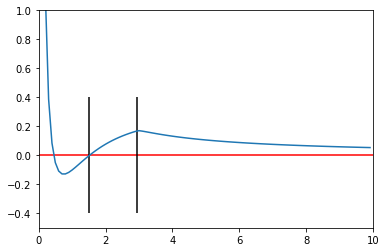

In [96]:
import matplotlib.pyplot as plt
plt.plot(distances, E_total_list)
plt.hlines(0, 0, 10, color="red")
plt.axis([0, 10, -0.5, 1])
plt.vlines(1.4925, -0.4, 0.4, color="black")
plt.vlines(2.9412, -0.4, 0.4, color="black")